Configurações

In [ ]:
!pip install pyspark 

In [ ]:
#Configurando variável de ambiente 
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

Imports

In [ ]:
import pandas as pd
import numpy as np

import pyspark.pandas as ps #pyspark-on-pandas 
from pyspark.sql import SparkSession #Iniciando uma sessão Spark, permitindo acesso as funcionalidades do Spark 
from pyspark import SparkContext

Básico

In [ ]:
#Criando um "pandas-on-Spark" dataframe 
psdf = ps.DataFrame(
    {'a': [1, 2, 3, 4, 5, 6],
     'b': [100, 200, 300, 400, 500, 600],
     'c': ["one", "two", "three", "four", "five", "six"]},
    index=[10, 20, 30, 40, 50, 60])

psdf

In [ ]:
#Criando um dataframe com datas de 6 meses 
#formato year-month-day
dates = pd.date_range('20230101', periods=6)
dates

In [ ]:
#Criando um dataframe com as datas como indíces
pdf = pd.DataFrame(np.random.randn(6, 4), index=dates, columns=list('ABCD'))
pdf

In [ ]:
#Convertendo um df pandas em um "pandas-on-Spark" dataframe 
psdf_1 = ps.from_pandas(pdf)
print("Tipo:", type(psdf_1))

psdf_1 #Se comporta igual a df do pandas

In [ ]:
#Funcionalidades do pandas podem ser usadas aqui 
psdf_1.dtypes

In [ ]:
psdf_1.index

In [ ]:
psdf_1.columns

In [ ]:
psdf_1.head(2)

In [ ]:
psdf_1.describe()

In [ ]:
pdf_2 = pdf.reindex(index=dates[0:4], columns=list(pdf.columns) + ['E'])
pdf_2.loc[dates[0]:dates[1], 'E'] = 1 #acessando um grupo de linhas por uma label 
psdf_2 = ps.from_pandas(pdf_2) 

psdf_2

In [ ]:
psdf_2.fillna(value=5) #preenchendo valores NaN com 5.0 

In [ ]:
#Outra forma de criar um dataframe spark através de um dataframe pandas 

#recuperando uma sessão spark já criada; caso não exista, uma nova sessão é criada.
spark = SparkSession.builder.getOrCreate() 
sdf = spark.createDataFrame(pdf)
sdf.show()

SQL

In [ ]:
#Criando um novo dataframe spark 
df = spark.createDataFrame([("Scala", 25000), ("Spark", 35000), ("PHP", 21000)])
df.show()

df.createOrReplaceTempView("sample_table") #Cria uma tabela temporária a partir de um dataframe spark 
df2 = spark.sql("SELECT _2 FROM sample_table") #Fazendo um select com sql 
df2.show()

In [ ]:
#Carregando dataset 
ds = spark.read.csv('data.csv', header=True)
ds.createOrReplaceTempView("car_table")

#Utilizando sql nos dados
ds1 = spark.sql("SELECT Year from car_table") 
ds1.show()

**SparkContext & RDD**

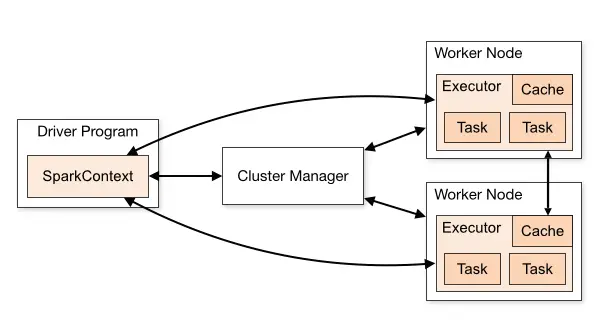

**Spark context** - representa a conexão entre o código python e o cluster spark.  Ele é responsável por coordenar a execução dos trabalhos no cluster, distribuir as tarefas entre os nós e manter a comunicação entre o driver (programa que controla o fluxo da aplicação) e os executores (processos que executam as tarefas nos nós do cluster). Pode ser usada de forma local ou distribuída. 

**RDD** - Resilient Distributed Dataset

In [ ]:
# Criando uma SparkSession para criar um SparkContext

spark = SparkSession.builder.master("local[1]") \
                    .appName('SparkByExamples.com') \
                    .getOrCreate()
print(spark.sparkContext)
print("Spark App Name : "+ spark.sparkContext.appName)

In [ ]:
# Criando um RDD a partir de um sparkContext  
#parallelize(),  textFile() e wholeTextFiles() são métodos que criam um RDD e o particionam baseado nos recursos disponíveis

data = [1,2,3,4,5,6,7,8,9,10,11,12]
rdd=spark.sparkContext.parallelize(data)

print(rdd.collect())

In [ ]:
#Recuperando quantidade de partições de um RDD
print("Quantidade de partições:"+str(rdd.getNumPartitions()))

In [ ]:
#Reparticionando o RDD
reparRdd = rdd.repartition(4)
print("Quantidade de repartições:"+str(reparRdd.getNumPartitions()))

In [ ]:
#Contando os itens do RDD
print("Quantidade : "+str(reparRdd.count()))

MapReduce

In [ ]:
#Aplicando uma função map com o dobro do valor
rdd2 = rdd.map(lambda x: x*2)
rdd2.collect()

In [ ]:
#Aplicando a função reduce aos dados de rdd2 
rdd3 = rdd2.reduce(lambda a,b: a+b)
rdd3

Transformações com Spark

In [ ]:
#Lendo um dado .txt
rdd4 = spark.sparkContext.textFile("test.txt")
for element in rdd4.collect():
    print(element)

In [ ]:
#Separando as strings por espaço
rdd5=rdd4.flatMap(lambda x: x.split(" "))
for element in rdd5.collect():
    print(element)

In [ ]:
#Adicionando uma nova coluna com valor 1 para cada palavra 
rdd6=rdd5.map(lambda x: (x,1))
for element in rdd6.collect():
    print(element)

In [ ]:
#Fazendo merge das strings iguais através da função
rdd7=rdd6.reduceByKey(lambda a, b: a+b)
for element in rdd7.collect():
    print(element)

In [ ]:
#Ordenando os dados por keys
rdd8 = rdd7.map(lambda x: (x[1],x[0])).sortByKey()
for element in rdd8.collect():
    print(element)

In [ ]:
#Filtrando palavras que possuem a letra "a"
rdd9 = rdd8.filter(lambda x : 'a' in x[1])
for element in rdd9.collect():
    print(element)